# Notebook 3: EDA Features
## Objectif
- Charger dataset_enrichi.csv
- Vérifier absence variables sensibles
- Analyse NA + corrélations (comme NB1)
- Export dataset_final.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
from pathlib import Path

outputs_path = Path('./outputs')

## 1. Charger dataset_enrichi.csv

In [2]:
df = pd.read_csv(outputs_path / 'dataset_enrichi.csv')
print(f'Dataset chargé: {df.shape}')
print(df.head())

Dataset chargé: (4410, 29)
   Attrition     BusinessTravel              Department  DistanceFromHome  \
0          0      Travel_Rarely                   Sales                 6   
1          1  Travel_Frequently  Research & Development                10   
2          0  Travel_Frequently  Research & Development                17   
3          0         Non-Travel  Research & Development                 2   
4          0      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeID  JobLevel                    JobRole  \
0          2  Life Sciences           1         1  Healthcare Representative   
1          1  Life Sciences           2         1         Research Scientist   
2          4          Other           3         4            Sales Executive   
3          5  Life Sciences           4         3            Human Resources   
4          1        Medical           5         1            Sales Executive   

   MonthlyIncome  ...  JobSat

## 2. Vérifier absence variables sensibles

In [3]:
sensitive_vars = ['EmployeeID', 'DistanceFromHome', 'PhoneNumber', 'Email', 'Address', 'Gender', 'Age', 'MaritalStatus']
found_sensitive = [col for col in sensitive_vars if col in df.columns]

if found_sensitive:
    print(f'ALERTE: Variables sensibles trouvées: {found_sensitive}')
    print('Suppression avant modélisation...')
    df = df.drop(columns=found_sensitive, errors='ignore')
else:
    print('Aucune variable sensible détectée.')
print(f'\nColonnes finales (prêtes pour modélisation): {df.columns.tolist()}')

ALERTE: Variables sensibles trouvées: ['EmployeeID', 'DistanceFromHome']
Suppression avant modélisation...

Colonnes finales (prêtes pour modélisation): ['Attrition', 'BusinessTravel', 'Department', 'Education', 'EducationField', 'JobLevel', 'JobRole', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'work_duration_mean', 'arrival_hour_mean', 'depart_hour_mean', 'overtime_rate', 'n_work_days', 'attendance_rate']


## 3. Analyse des valeurs manquantes

In [4]:
print('\n=== VALEURS MANQUANTES ===')
missing_count = df.isnull().sum()
missing_pct = (missing_count / len(df) * 100)
missing_df = pd.DataFrame({'count': missing_count, 'percentage': missing_pct})
missing_df = missing_df[missing_df['count'] > 0].sort_values('count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print('✓ Aucune valeur manquante')

print(f'\nShape: {df.shape}')
print(f'Total manquants: {missing_count.sum()}')


=== VALEURS MANQUANTES ===
                         count  percentage
WorkLifeBalance             38    0.861678
EnvironmentSatisfaction     25    0.566893
JobSatisfaction             20    0.453515
NumCompaniesWorked          19    0.430839
TotalWorkingYears            9    0.204082

Shape: (4410, 27)
Total manquants: 111


## 4. Corrélations numériques vs cible (Pearson)

In [5]:
# Identifier colonnes
target_col = 'Attrition'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

print('\n=== CORRÉLATIONS PEARSON vs ATTRITION ===')
correlations = df[numeric_cols + [target_col]].corr()[target_col].sort_values(ascending=False)
print(correlations)

# Top 10 features
top_n = 10
top_features = correlations.abs().sort_values(ascending=False)[1:top_n+1]
print(f'\nTop {top_n} features (par abs(corr)):')  
for feat, corr_val in top_features.items():
    actual_corr = correlations[feat]
    print(f'  {feat}: {actual_corr:.4f}')


=== CORRÉLATIONS PEARSON vs ATTRITION ===
Attrition                  1.000000
overtime_rate              0.233609
depart_hour_mean           0.201700
work_duration_mean         0.201688
attendance_rate            0.043517
n_work_days                0.043517
NumCompaniesWorked         0.042345
PercentSalaryHike          0.032533
PerformanceRating          0.023403
StockOptionLevel          -0.006839
JobLevel                  -0.010290
arrival_hour_mean         -0.013089
Education                 -0.015111
JobInvolvement            -0.015588
MonthlyIncome             -0.031176
YearsSinceLastPromotion   -0.033019
TrainingTimesLastYear     -0.049431
WorkLifeBalance           -0.062756
EnvironmentSatisfaction   -0.102142
JobSatisfaction           -0.102847
YearsAtCompany            -0.134392
YearsWithCurrManager      -0.156199
TotalWorkingYears         -0.170338
Name: Attrition, dtype: float64

Top 10 features (par abs(corr)):
  overtime_rate: 0.2336
  depart_hour_mean: 0.2017
  work_durat

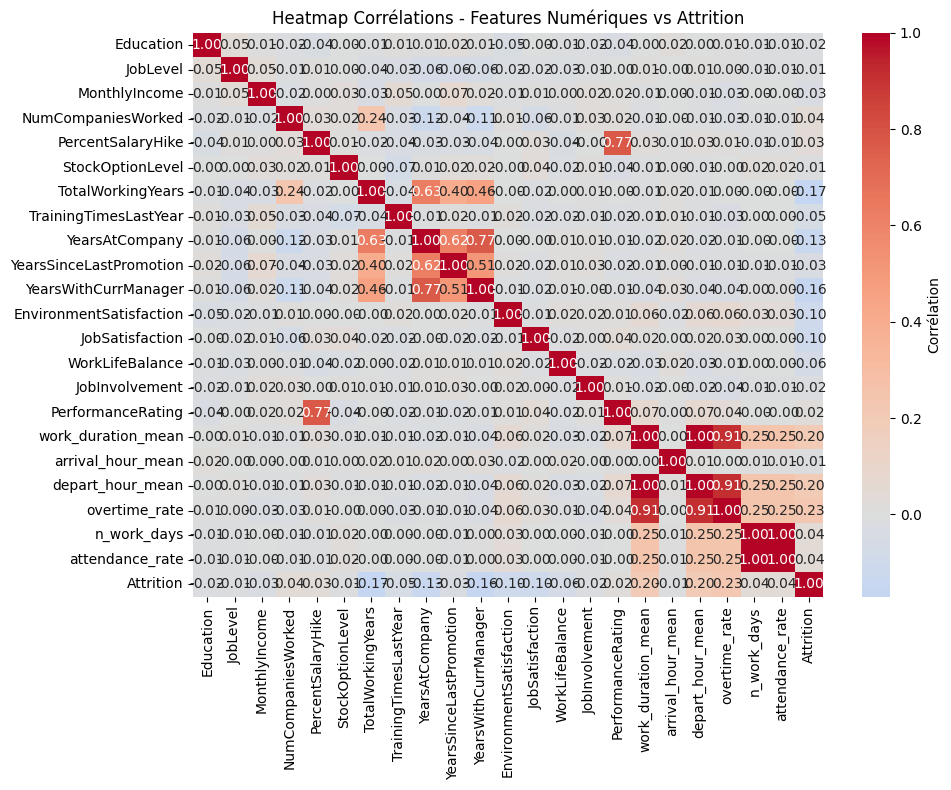

In [6]:
# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
if len(numeric_cols) > 0:
    corr_matrix = df[numeric_cols + [target_col]].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                ax=ax, cbar_kws={'label': 'Corrélation'})
    plt.title('Heatmap Corrélations - Features Numériques vs Attrition')
    plt.tight_layout()
    plt.show()
    plt.close()

## 5. Corrélations catégoriques vs cible (Cramér's V)

In [7]:
def cramers_v_score(x, y):
    """Cramér's V statistic"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    if min_dim == 0:
        return 0
    return np.sqrt(chi2 / (n * min_dim))

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print('\n=== CORRÉLATIONS CATÉGORIQUES (Cramér\'s V) ===')
cat_corr = {}
for col in categorical_cols:
    v = cramers_v_score(df[col], df[target_col])
    cat_corr[col] = v

cat_corr_sorted = sorted(cat_corr.items(), key=lambda x: x[1], reverse=True)
for col, val in cat_corr_sorted:
    print(f'  {col}: {val:.4f}')


=== CORRÉLATIONS CATÉGORIQUES (Cramér's V) ===
  BusinessTravel: 0.1283
  EducationField: 0.1023
  Department: 0.0812
  JobRole: 0.0755


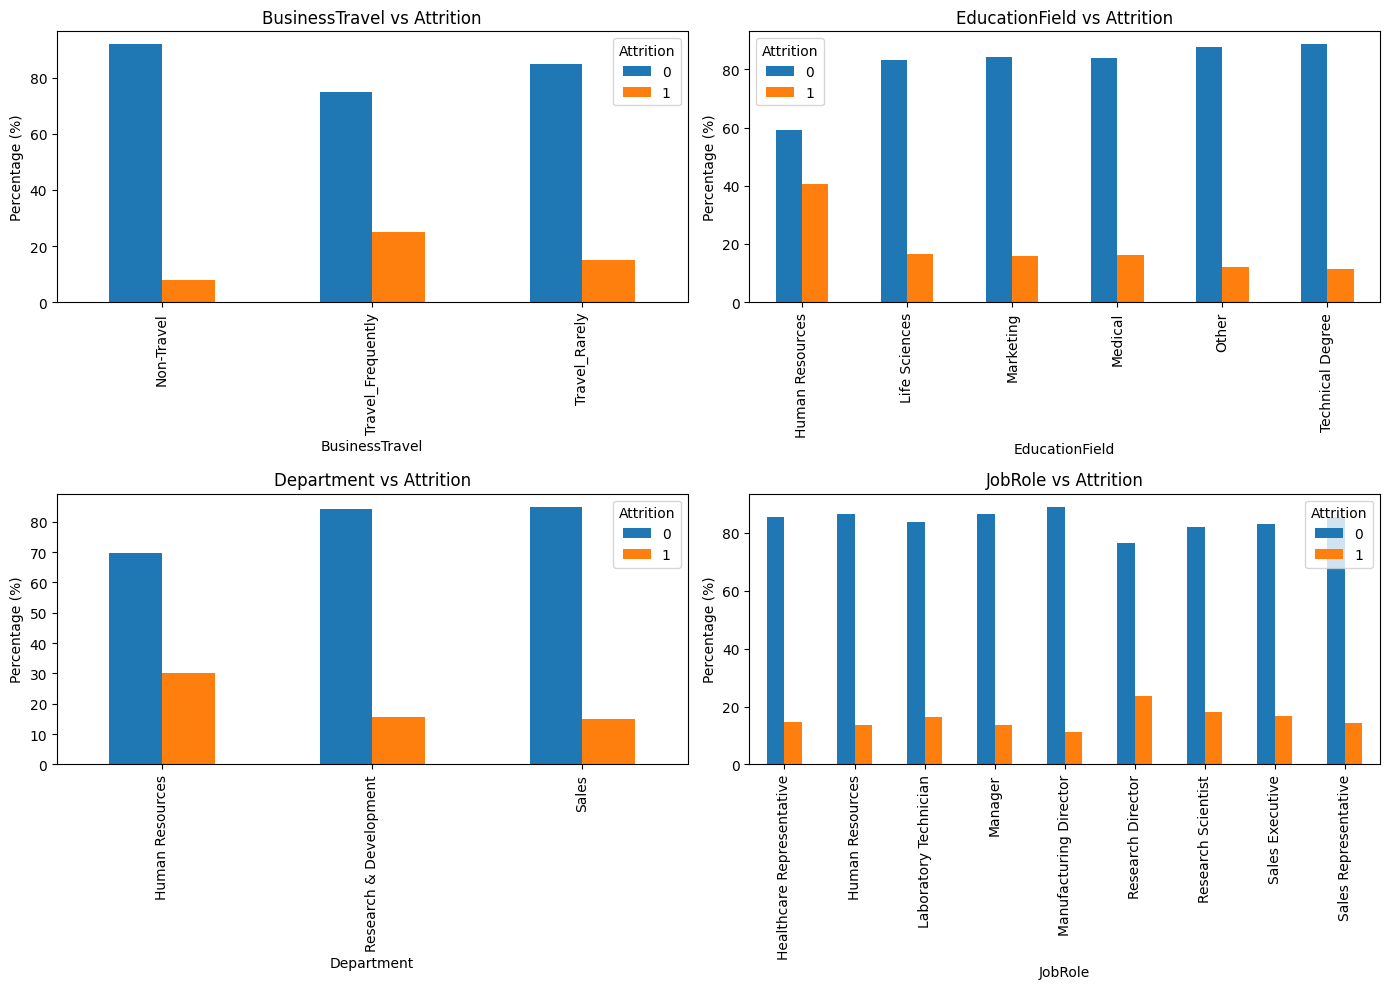

In [8]:
# Visualiser top catégories
if len(categorical_cols) > 0:
    n_plots = min(4, len(categorical_cols))
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    top_cats = [col for col, _ in cat_corr_sorted[:n_plots]]
    for idx, col in enumerate(top_cats):
        ct = pd.crosstab(df[col], df[target_col], normalize='index') * 100
        ct.plot(kind='bar', ax=axes[idx], title=f'{col} vs {target_col}')
        axes[idx].set_ylabel('Percentage (%)')
        axes[idx].set_xlabel(col)
        axes[idx].legend(title=target_col)
    
    plt.tight_layout()
    plt.show()
    plt.close()

## 6. Statistiques descriptives finales

In [9]:
print('\n=== STATISTIQUES DESCRIPTIVES ===')
print(df.describe())
print(f'\nDistribution Attrition:')
print(df[target_col].value_counts())
print(f'Attrition %: {df[target_col].mean()*100:.2f}%')


=== STATISTIQUES DESCRIPTIVES ===
         Attrition    Education     JobLevel  MonthlyIncome  \
count  4410.000000  4410.000000  4410.000000    4410.000000   
mean      0.161224     2.912925     2.063946   65029.312925   
std       0.367780     1.023933     1.106689   47068.888559   
min       0.000000     1.000000     1.000000   10090.000000   
25%       0.000000     2.000000     1.000000   29110.000000   
50%       0.000000     3.000000     2.000000   49190.000000   
75%       0.000000     4.000000     3.000000   83800.000000   
max       1.000000     5.000000     5.000000  199990.000000   

       NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  \
count         4391.000000        4410.000000       4410.000000   
mean             2.694830          15.209524          0.793878   
std              2.498887           3.659108          0.851883   
min              0.000000          11.000000          0.000000   
25%              1.000000          12.000000          0.000000   
5

## 7. Export dataset_final.csv

In [10]:
output_file = outputs_path / 'dataset_final.csv'
df.to_csv(output_file, index=False)

print(f'\n✓ Dataset final exporté: {output_file}')
print(f'  Shape: {df.shape}')
print(f'  Colonnes: {df.columns.tolist()}')


✓ Dataset final exporté: outputs\dataset_final.csv
  Shape: (4410, 27)
  Colonnes: ['Attrition', 'BusinessTravel', 'Department', 'Education', 'EducationField', 'JobLevel', 'JobRole', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'work_duration_mean', 'arrival_hour_mean', 'depart_hour_mean', 'overtime_rate', 'n_work_days', 'attendance_rate']
